# **1. Instalasi dan mengimpor library yang dibutuhkan**

In [4]:
# Instalasi pustaka yang dibutuhkan
!pip install Sastrawi
!pip install gensim

In [5]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import json
import requests
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download as nltk_unduh
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
# Mengunduh dependensi NLTK
nltk_unduh('punkt')
nltk_unduh('punkt_tab')
nltk_unduh('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Pustaka untuk machine learning dan deep learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

# **2. Membaca dataset dan melakukan proses EDA**

In [10]:
# Memuat dataset ulasan aplikasi Access By KAI
file_path = "/content/sample_data/hasil-scrapping-kai.csv"
df = pd.read_csv(file_path)

In [11]:
# Menampilkan beberapa baris awal dari dataset
print("Contoh data ulasan:")
df.head()

Contoh data ulasan:


,content,score
0,Aplikasi KAI Acces sebelumnya lebih simple dan...,1
1,Pemesanan mll KAI Acces kereeen.. Tapi ada yg ...,5
2,"Tolong ya min aplikasi nya di perbaiki lagi, p...",1
3,kalau waktu musim liburan sekolah/lebaran sela...,1
4,"Terdapat masalah ""Request processing failed; n...",1


In [13]:
# Menampilkan informasi ringkas dari DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  30000 non-null  object
 1   score    30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB


**Exploratory Data Analysis (EDA)**

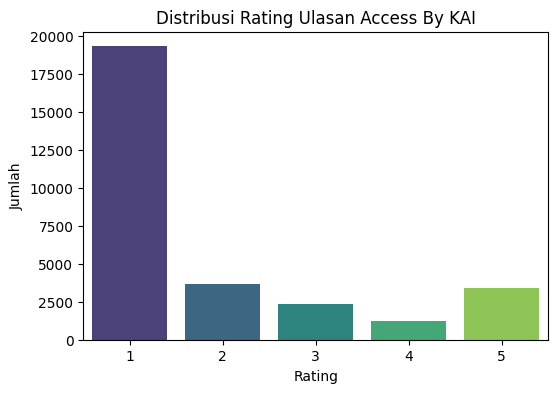

score
1    19303
2     3672
5     3408
3     2355
4     1262
Name: count, dtype: int64


In [15]:
# Distribusi rating
plt.figure(figsize=(6, 4))
sns.countplot(x=df['score'], palette='viridis')
plt.title("Distribusi Rating Ulasan Access By KAI")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

print(df['score'].value_counts())

# **3. Text Preprocessing**

In [16]:
# Fungsi untuk membersihkan teks
def proses_teks(teks):
    teks = re.sub(r'@[A-Za-z0-9_]+', '', teks)       # Menghapus mention
    teks = re.sub(r'#[A-Za-z0-9_]+', '', teks)       # Menghapus hashtag
    teks = re.sub(r'[²]', ' ', teks)                 # Menghapus karakter khusus
    teks = re.sub(r'\d+', ' ', teks)                 # Menghapus angka
    teks = re.sub(r'[^\w\s]', ' ', teks)             # Menghapus tanda baca
    teks = teks.strip()                              # Menghapus spasi ekstra
    teks = teks.lower()                              # Konversi ke huruf kecil
    return teks

In [17]:
# Fungsi untuk tokenisasi
def tokenisasi_teks(teks):
    return word_tokenize(teks)

In [18]:
# Fungsi untuk menghapus stopwords
def filter_stopwords(teks):
    daftar_stopwords = set(stopwords.words('indonesian'))
    daftar_stopwords_english = set(stopwords.words('english'))
    daftar_stopwords.update(daftar_stopwords_english)
    daftar_stopwords.update([
        'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku',
        'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy'
    ])
    return [kata for kata in teks if kata not in daftar_stopwords]

In [19]:
# Memuat lexicon positif dan negatif
url_positif = "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt"
lexikon_positif = set(kata.strip() for kata in requests.get(url_positif).text.split("\n") if kata.strip())

url_negatif = "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt"
lexikon_negatif = set(kata.strip() for kata in requests.get(url_negatif).text.split("\n") if kata.strip())

In [20]:
# Tampilkan statistik leksikon
print(f"Jumlah kata positif: {len(lexikon_positif)}")
print(f"Jumlah kata negatif: {len(lexikon_negatif)}")

Jumlah kata positif: 1182
Jumlah kata negatif: 2402


In [22]:
# Memuat dan mendefinisikan kata slang
kata_slang = {
    'yg': 'yang',
    'dg': 'dengan',
    'dgn': 'dengan',
    'tdk': 'tidak',
    'ga': 'tidak',
    'gak': 'tidak',
    'jgn': 'jangan',
    # Jika ingin menambahkan kata slang dapat ditambahkan pada baris ini
}

def perbaiki_kata_slang(teks):
    kata_kata = teks.split()
    kata_diperbaiki = [
        kata_slang[kata.lower()] if kata.lower() in kata_slang else kata
        for kata in kata_kata
    ]
    return ' '.join(kata_diperbaiki)

In [23]:
# Fungsi untuk menggabungkan token menjadi kalimat
def gabungkan_ke_kalimat(tokens):
    return ' '.join(tokens)

In [24]:
# Proses preprocessing teks
df['clean_text'] = df['content'].apply(proses_teks)
df['text_slangwords'] = df['clean_text'].apply(perbaiki_kata_slang)
df['text_tokenizing'] = df['text_slangwords'].apply(tokenisasi_teks)
df['text_stopword'] = df['text_tokenizing'].apply(filter_stopwords)
df['clean_content'] = df['text_stopword'].apply(gabungkan_ke_kalimat)

In [25]:
# Menentukan label sentimen berdasarkan leksikon
def tentukan_sentimen(teks):
    skor = 0
    for kata in teks:
        if kata in lexikon_positif:
            skor += 1
        if kata in lexikon_negatif:
            skor -= 1

    if skor > 0:
        sentimen = 'positif'
    elif skor < 0:
        sentimen = 'negatif'
    else:
        sentimen = 'netral'

    return skor, sentimen

# Terapkan pelabelan sentimen ke kolom 'text_stopword'
hasil_sentimen = df['text_stopword'].apply(tentukan_sentimen)
hasil_sentimen = list(zip(*hasil_sentimen))
df['sentimen_skor'] = hasil_sentimen[0]
df['sentimen'] = hasil_sentimen[1]

# Tampilkan jumlah masing-masing kategori sentimen
print(df['sentimen'].value_counts())

sentimen
negatif    12764
netral     10701
positif     6535
Name: count, dtype: int64


Hal paling sulit adalah membagi distribusi ulasan yang didapatkan sampai mencapai distribusi ulasan yang seimbang sehingga akan menghasilkan akurasi model yang baik, berikut awal coding yang saya buat, namun selalu gagal ketika dilakukan pembagian distribusi yang seimbang.

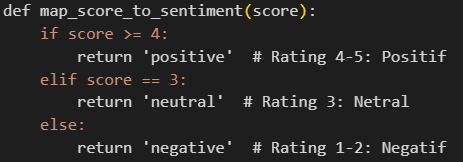

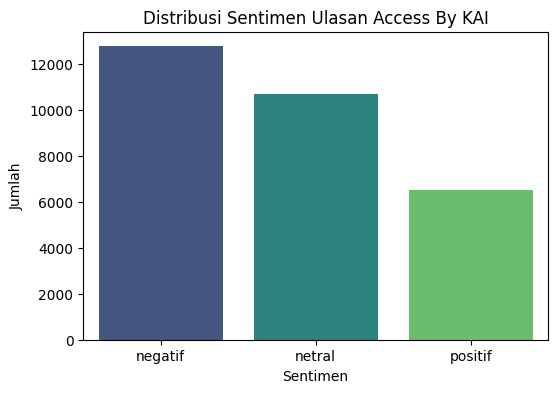

sentimen
negatif    12764
netral     10701
positif     6535
Name: count, dtype: int64


In [26]:
# Visualisasi distribusi sentimen
plt.figure(figsize=(6, 4))
sns.countplot(x=df['sentimen'], palette='viridis')
plt.title("Distribusi Sentimen Ulasan Access By KAI")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

print(df['sentimen'].value_counts())

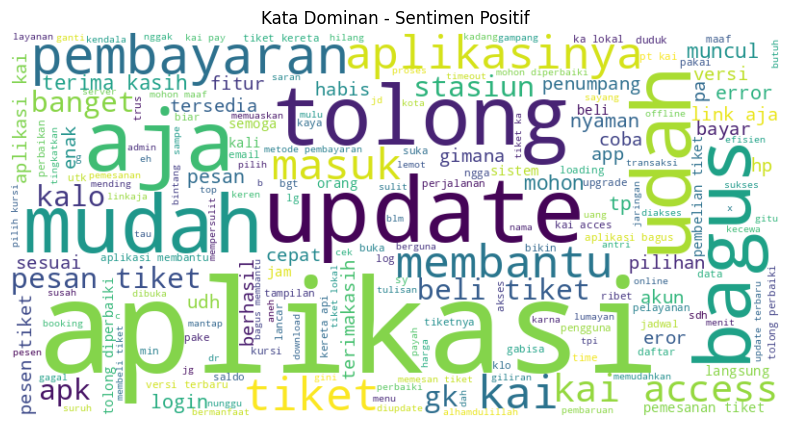

In [27]:
# WordCloud untuk sentimen positif
positive_text = ' '.join(df[df['sentimen'] == 'positif']['clean_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Kata Dominan - Sentimen Positif')
plt.show()

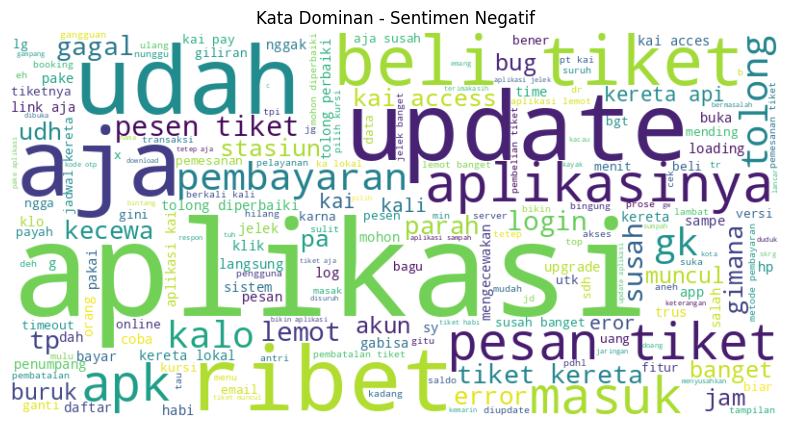

In [28]:
# WordCloud untuk sentimen negatif
positive_text = ' '.join(df[df['sentimen'] == 'negatif']['clean_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Kata Dominan - Sentimen Negatif')
plt.show()

# **Skema 1 : LSTM + WordEmbedding (80/20)**

In [29]:
# Tokenization dan Padding
tokenizer_lstm = Tokenizer(num_words=5000)
tokenizer_lstm.fit_on_texts(df['clean_content'])
sequences = tokenizer_lstm.texts_to_sequences(df['clean_content'])
padded_sequences = pad_sequences(sequences, maxlen=100)

In [30]:
# Encoding label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['sentimen'])
y_categorical = to_categorical(y_encoded)

In [31]:
# Membagi data latih dan data uji (80/20)
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    padded_sequences, y_categorical, test_size=0.2, random_state=42, stratify=df['sentimen']
)

In [32]:
# Membangun Model LSTM
model_dl = Sequential([
    Embedding(input_dim=5000, output_dim=100, input_length=100),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_dl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
]

history = model_dl.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=20, batch_size=32, callbacks=callbacks
)

y_pred_dl = model_dl.predict(X_test_dl)
y_pred_dl_classes = np.argmax(y_pred_dl, axis=1)
y_true_dl = np.argmax(y_test_dl, axis=1)

print("Akurasi Deep Learning:", accuracy_score(y_true_dl, y_pred_dl_classes))
print(classification_report(y_true_dl, y_pred_dl_classes, target_names=label_encoder.classes_))

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 185s 240ms/step - accuracy: 0.6024 - loss: 1.0929 - val_accuracy: 0.9245 - val_loss: 0.2710 - learning_rate: 0.0010
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 207s 247ms/step - accuracy: 0.9269 - loss: 0.2444 - val_accuracy: 0.9442 - val_loss: 0.2038 - learning_rate: 0.0010
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 195s 238ms/step - accuracy: 0.9615 - loss: 0.1542 - val_accuracy: 0.9242 - val_loss: 0.2585 - learning_rate: 0.0010
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 189s 252ms/step - accuracy: 0.9682 - loss: 0.1298 - val_accuracy: 0.9460 - val_loss: 0.1949 - learning_rate: 0.0010
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 207s 258ms/step - accuracy: 0.9734 - loss: 0.1118 - val_accuracy: 0.9580 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 195s 248ms/step - accuracy: 0.9784 - loss: 0.0982 - val_accuracy: 0.9617 - val_loss: 0.1788 - learning_rate: 0.0010
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 199s 244ms/step - accura

In [33]:
# Cetak metrik epoch terakhir
last = len(history.history['loss']) - 1
print(f"\n=== Epoch Terakhir (Epoch {last+1}) ===")
print(f"Train Accuracy   : {history.history['accuracy'][last]:.4f}")
print(f"Val Accuracy     : {history.history['val_accuracy'][last]:.4f}")
print(f"Train Loss       : {history.history['loss'][last]:.4f}")
print(f"Val Loss         : {history.history['val_loss'][last]:.4f}")


=== Epoch Terakhir (Epoch 8) ===
Train Accuracy   : 0.9888
Val Accuracy     : 0.9630
Train Loss       : 0.0659
Val Loss         : 0.1739


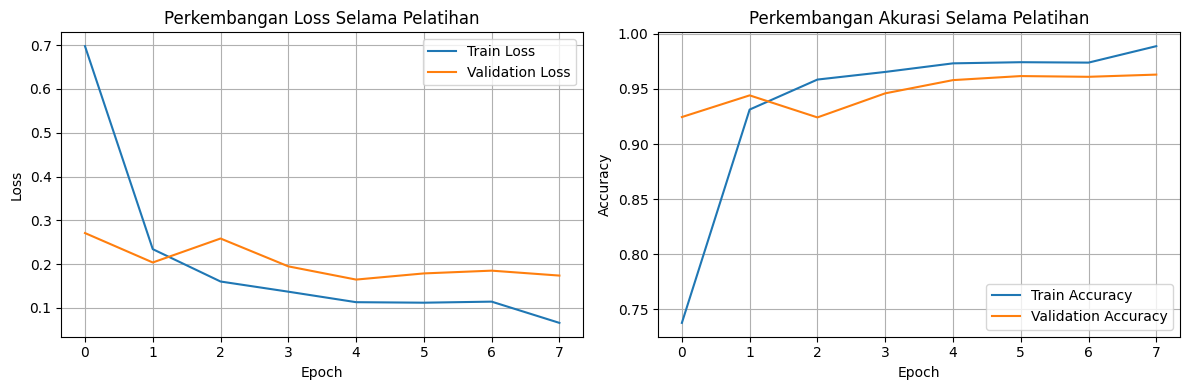

In [38]:
# Membuat visualisasi grafik perkembangan loss dan akurasi selama pelatihan
plt.figure(figsize=(12, 4))

# Grafik Loss (kiri)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perkembangan Loss Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Grafik Akurasi (kanan)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Perkembangan Akurasi Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Atur layout agar tidak saling tumpang tindih
plt.tight_layout()
plt.show()

Berdasarkan grafik perkembangan loss dan akurasi selama proses pelatihan menggunakan metode LSTM + WordEmbedding (80/20), dapat disimpulkan bahwa:

1. Model menunjukkan performa pelatihan yang baik, ditandai dengan penurunan nilai train loss secara konsisten dan peningkatan train accuracy yang signifikan dari epoch ke-0 hingga epoch ke-7.

2. Nilai validation loss juga menurun secara keseluruhan meskipun sempat mengalami sedikit fluktuasi di awal, namun stabil di bawah 0.2 setelah beberapa epoch. Hal ini menunjukkan bahwa model mampu melakukan generalisasi dengan cukup baik terhadap data yang belum pernah dilihat sebelumnya.

3. Akurasi validasi meningkat dan stabil di atas 95%, menunjukkan bahwa model tidak hanya menghafal data pelatihan, tetapi juga mampu memprediksi data validasi dengan tingkat akurasi yang tinggi.

4. Tidak terdapat indikasi overfitting yang signifikan, karena perbedaan antara train accuracy dan validation accuracy relatif kecil, dan validation loss tidak mengalami kenaikan drastis.

# **Skema 2 : SVM & TF-IDF (70/30)**

In [39]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['clean_content'])

# Membagi data latih dan data uji (70/30)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_tfidf, df['sentimen'], test_size=0.3, random_state=42, stratify=df['sentimen']
)

# Training SVM
model_svm = SVC(kernel='linear', probability=True)
model_svm.fit(X_train_svm, y_train_svm)

# Evaluasi Model
y_pred_svm = model_svm.predict(X_test_svm)
print("Akurasi SVM:", accuracy_score(y_test_svm, y_pred_svm))
print(classification_report(y_test_svm, y_pred_svm))

Akurasi SVM: 0.9214444444444444
              precision    recall  f1-score   support

     negatif       0.96      0.94      0.95      3829
      netral       0.86      0.94      0.90      3210
     positif       0.95      0.87      0.91      1961

    accuracy                           0.92      9000
   macro avg       0.93      0.91      0.92      9000
weighted avg       0.92      0.92      0.92      9000



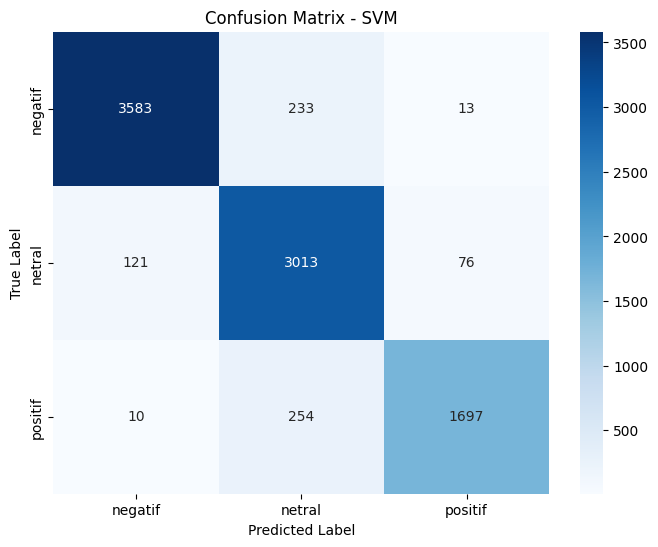

In [44]:
# Membuat dan Menampilkan Confusion Matrix
cm = confusion_matrix(y_test_svm, y_pred_svm)
labels = sorted(df['sentimen'].unique())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM')
plt.show()

Model Support Vector Machine (SVM) yang digunakan untuk mengklasifikasikan sentimen (negatif, netral, dan positif) menunjukkan hasil yang sangat baik. Dengan tingkat akurasi sebesar 92%, model ini mampu mengenali sentimen dari teks dengan cukup akurat.

Secara keseluruhan:

1. Sentimen negatif paling mudah dikenali oleh model, dengan tingkat ketepatan yang tinggi.

2. Sentimen netral sedikit lebih sulit dibedakan, kadang masih tertukar dengan negatif atau positif.

3. Sentimen positif juga dikenali dengan cukup baik, meskipun masih ada beberapa yang salah diklasifikasikan sebagai netral.

Confusion Matrix:
1. Kelas Negatif (3829): Sebagian besar data negatif (3583) diklasifikasikan dengan benar, tetapi ada sedikit kesalahan dengan 233 data yang salah diklasifikasikan sebagai netral, dan 13 sebagai positif.

2. Kelas Netral (3210): Kelas netral memiliki tingkat kesalahan yang lebih tinggi, dengan 121 data netral diklasifikasikan sebagai negatif dan 76 sebagai positif.

3. Kelas Positif (1961): Kelas positif memiliki sedikit kesalahan, dengan 10 data positif yang diklasifikasikan sebagai negatif dan 254 sebagai netral.

# **Skema 3 : CNN+LSTM (70/30)**

In [56]:
# Tokenization dan Padding
max_features = 10000  # Jumlah kata unik yang akan digunakan
max_len = 150         # Panjang maksimum setiap sequence

tokenizer_cnn_lstm = Tokenizer(num_words=max_features)
tokenizer_cnn_lstm.fit_on_texts(df['clean_content'])

# Ubah teks menjadi sequences
X_sequences = tokenizer_cnn_lstm.texts_to_sequences(df['clean_content'])
X_padded = pad_sequences(X_sequences, maxlen=max_len)

# Encoding label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['sentimen'])
y_categorical = tf.keras.utils.to_categorical(y_encoded)

# Pembagian data 70/30
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_padded, y_categorical, test_size=0.3, random_state=42, stratify=df['sentimen']
)

In [57]:
# Parameter model
embedding_dim = 200  # Dimensi embedding
num_classes = len(df['sentimen'].unique())  # Jumlah kelas sentimen

# Membangun model CNN + LSTM
model_cnn = Sequential()

# Embedding layer
model_cnn.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_len))

# CNN layer
model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

# LSTM layer
model_cnn.add(LSTM(64, return_sequences=False))

# Fully connected layers
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(num_classes, activation='softmax'))

# Compile model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ringkasan model
model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
]

# Pelatihan model
history = model_cnn.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 104s 305ms/step - accuracy: 0.6397 - loss: 0.7563 - val_accuracy: 0.9477 - val_loss: 0.1688 - learning_rate: 0.0010
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 141s 302ms/step - accuracy: 0.9652 - loss: 0.1222 - val_accuracy: 0.9526 - val_loss: 0.1528 - learning_rate: 0.0010
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 145s 312ms/step - accuracy: 0.9802 - loss: 0.0679 - val_accuracy: 0.9608 - val_loss: 0.1479 - learning_rate: 0.0010
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 98s 297ms/step - accuracy: 0.9901 - loss: 0.0392 - val_accuracy: 0.9541 - val_loss: 0.1871 - learning_rate: 0.0010
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 141s 294ms/step - accuracy: 0.9933 - loss: 0.0248 - val_accuracy: 0.9650 - val_loss: 0.1637 - learning_rate: 0.0010
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 97s 295ms/step - accuracy: 0.9948 - loss: 0.0207 - val_accuracy: 0.9646 - val_loss: 0.1775 - learning_rate: 0.0010
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 100s 303ms/step - accuracy

In [59]:
# Prediksi pada data uji
y_pred_dl = model_cnn.predict(X_test_dl)
y_pred_dl_classes = np.argmax(y_pred_dl, axis=1)
y_true_dl = np.argmax(y_test_dl, axis=1)

# Evaluasi akurasi
accuracy_dl = accuracy_score(y_true_dl, y_pred_dl_classes)
print("Akurasi CNN + LSTM:", accuracy_dl)
print(classification_report(y_true_dl, y_pred_dl_classes, target_names=label_encoder.classes_))

282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step
Akurasi CNN + LSTM: 0.9607777777777777
              precision    recall  f1-score   support

     negatif       0.98      0.96      0.97      3829
      netral       0.93      0.96      0.95      3210
     positif       0.97      0.96      0.97      1961

    accuracy                           0.96      9000
   macro avg       0.96      0.96      0.96      9000
weighted avg       0.96      0.96      0.96      9000



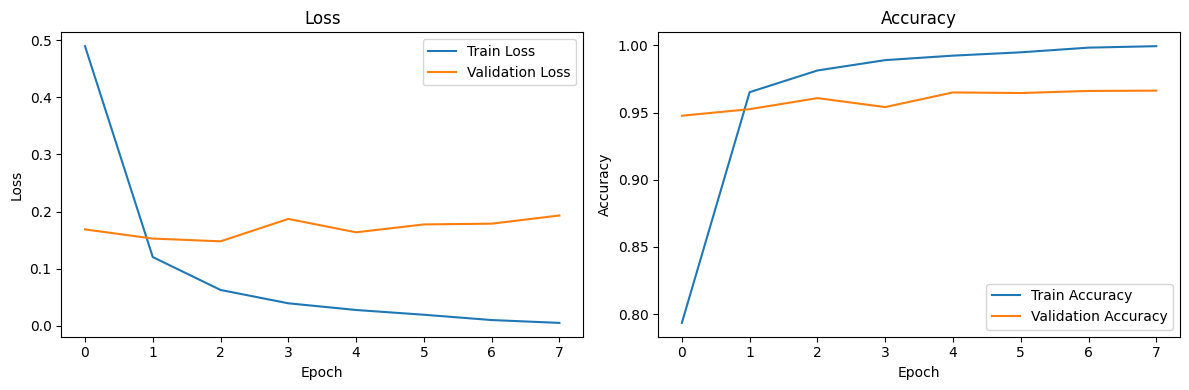

In [60]:
# Visualisasi perkembangan training
plt.figure(figsize=(12, 4))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grafik Akurasi
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Secara keseluruhan, model CNN + LSTM memiliki performa yang sangat baik dengan akurasi 96.08% , precision, recall, dan F1-Score yang tinggi di semua kelas sentimen. Model ini berhasil memprediksi sentimen dengan sangat baik, tanpa bias terhadap kelas tertentu. Grafik loss dan accuracy juga menunjukkan bahwa model tidak mengalami overfitting atau underfitting yang signifikan, serta memiliki generalisasi yang baik terhadap data baru.

# **Menyimpan hasil akurasi model yang telah dilatih**

In [61]:
# Hasil akurasi dari model-model yang telah dilatih
lstm_wordembedding_accuracy = 0.96  # LSTM + WordEmbedding (80/20)
svm_tfidf_accuracy = 0.92          # SVM + TF-IDF (80/20)
cnn_lstm_accuracy = 0.96           # CNN + LSTM (70/30)

In [62]:
# Membuat DataFrame untuk ringkasan akurasi
data = {
    'Model': ['LSTM + WordEmbedding', 'SVM + TF-IDF', 'CNN + LSTM'],
    'Pembagian Data': ['80/20', '70/30', '70/20'],
    'Metode Ekstraksi Fitur': ['Word Embedding', 'TF-IDF', 'Word Embedding'],
    'Akurasi': [lstm_wordembedding_accuracy, svm_tfidf_accuracy, cnn_lstm_accuracy]
}

# Buat DataFrame
df_summary = pd.DataFrame(data)

# Tampilkan ringkasan akurasi
print("Ringkasan Akurasi Model:")
print(df_summary)

Ringkasan Akurasi Model:
                  Model Pembagian Data Metode Ekstraksi Fitur  Akurasi
0  LSTM + WordEmbedding          80/20         Word Embedding     0.96
1          SVM + TF-IDF          70/30                 TF-IDF     0.92
2            CNN + LSTM          70/20         Word Embedding     0.96


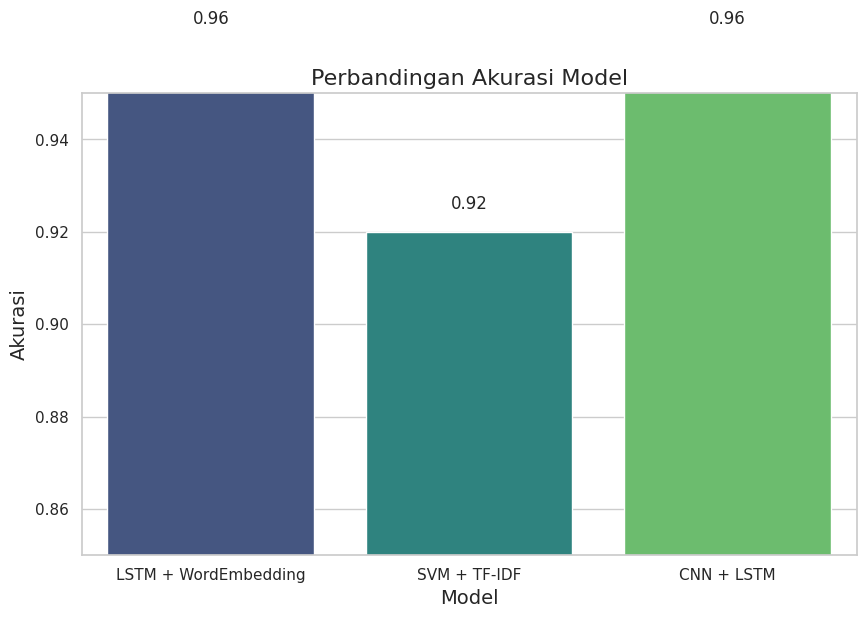

In [63]:
# Atur gaya seaborn
sns.set(style="whitegrid")

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Akurasi', data=df_summary, palette='viridis')

# Tambahkan nilai akurasi di atas setiap bar
for index, value in enumerate(df_summary['Akurasi']):
    plt.text(index, value + 0.005, f'{value:.2f}', ha='center', fontsize=12)

# Judul dan label sumbu
plt.title('Perbandingan Akurasi Model', fontsize=16)
plt.ylabel('Akurasi', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylim(0.85, 0.95)  # Batas sumbu Y agar lebih jelas
plt.show()

In [65]:
import pickle

# Simpan model SVM
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(model_svm, f)

# Simpan vectorizer TF-IDF
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Simpan model LSTM (format .keras)
model_dl.save('lstm_wordembedding_model.keras')

# Simpan tokenizer untuk LSTM
with open('lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer_lstm, f)

# Simpan model CNN+LSTM (format .keras)
model_cnn.save('cnn_lstm_model.keras')

# Simpan tokenizer untuk CNN+LSTM
with open('cnn_lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer_cnn_lstm, f)